In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.test.is_gpu_available()

In [ ]:
#Import data from preprocessing file
from ipynb.fs.full.data_preprocessing import send_freq_data, send_time_data
import matplotlib.pyplot as plt
import numpy as np

freq_data_train, fstrain_data_train, freq_data_test, fstrain_data_test = send_freq_data()
witness_data_train, tstrain_data_train, witness_data_test, tstrain_data_test = send_time_data()

print(witness_data_train.shape, tstrain_data_train.shape,
      witness_data_test.shape, tstrain_data_test.shape)

# DeepClean

In [ ]:
model = keras.models.Sequential(name="deepclean")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=7, strides=1, padding="same", activation="tanh",\
                        input_shape=(witness_data_train.shape[1], witness_data_train.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(filters=32, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=16, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=8, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=21, kernel_size=7, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=1, kernel_size=7, padding="same", name = "output"))

model.summary()

#non-trainable parameters come from the BatchNormalization

In [ ]:
frame_length = window_length
frame_step = window_size
fft_length = window_length*sample_rate

def custom_loss_function(y_true, y_pred):
    w = 0.8  # relative weight factor for J_asd 
    h = y_true
    r = tf.square(tf.subtract(y_true,y_pred))
    asdr = tf.signal.stft(r,frame_length=frame_length, 
                                     frame_step=frame_step, 
                                     fft_length=fft_length, 
                                     window_fn=tf.signal.hann_window)
    asdh = tf.signal.stft(h,frame_length=frame_length, 
                                     frame_step=frame_step, 
                                     fft_length=fft_length, 
                                     window_fn=tf.signal.hann_window)
    ratio = tf.abs(asdr)/tf.abs(asdh)
    J_asd = tf.reduce_mean(ratio)
    J_mse = tf.reduce_mean(r)
    J = w*J_asd + (1-w)*J_mse  #Net loss with weighted ASD and MSE loss components
    return J

In [ ]:
import numpy as np

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.8)

#model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
model.compile(loss=custom_loss_function, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

results = model.fit(
    witness_data_train,
    tstrain_data_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                keras.callbacks.EarlyStopping(patience=10, verbose=1),
    ],
)

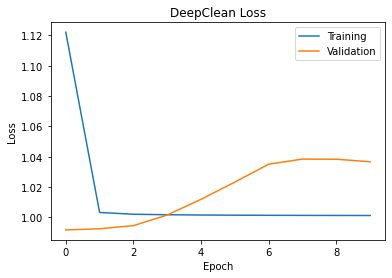

<Figure size 1440x720 with 0 Axes>

In [ ]:
#History plot from plotting.py
from matplotlib import figure
import matplotlib.pyplot as plt

loss = results.history["loss"]
val_loss = results.history["val_loss"]
n_epochs = len(loss)


plt.plot(np.arange(n_epochs), loss, label="Training")
plt.plot(np.arange(n_epochs), val_loss, label="Validation")
plt.legend()
plt.title("DeepClean Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim(0,0.01)
plt.figure(figsize=(20,10))
plt.savefig('DeepClean_loss')

In [ ]:
#model.predict() to produce predicted noise
noise_predict = model.predict(witness_data_test)
noise_predict = np.squeeze(noise_predict)

#reshape so strain_test and predicted 
#noise are both 2d
print(noise_predict.shape)

13/13 [==============================] - 1s 19ms/step
(409, 8192)


In [ ]:
#API Call to send to Postprocessing, WIP
def send_predicted_noise():
    """
    noise_predict = predicted noise from model.predict()
    must be postprocessed before subtracting from 
    time_strain data
    
    time_strain_data = original strain, subtract 
    noise_predict from it once its postprocessed to 
    get clean_data
    """
    return noise_predict, tstrain_data_test

# WIP

Tasks:

Modify parameters of interest and measure:
Training time
Validation time
Training loss
Validation loss